# Challenge 2 - Recommendation Engine

Build a recommendation engine for company ABC’s video streaming product. Currently, the videos shown on their home page to new users are manually chosen and you need to implement a recommendation engine to increase the conversation rate.

You have been presented with the following business questions:
1. Classify each video into the following buckets: 
    * **"Hot"** - means trending up. These videos are candidates to be shown.
    * **"Stable and Popular"** - video view counts are flat, but very high. These videos are candidates to be shown too.
    * **"Everything else"** - these videos won't be shown.
2. What are the main characteristics of the "hot videos"?
3. After having identified the characteristics of the hot videos, how would you use this information from a product standpoint?


In [2]:
# install packages if needed
list.of.packages <- c("dplyr","lubridate","ggplot2")
new.packages <- list.of.packages[!(list.of.packages %in% installed.packages()[,"Package"])]
if(length(new.packages)) install.packages(new.packages, repos = "http://cran.us.r-project.org")

In [4]:
library(dplyr)
library(lubridate)
library(readr)
library(ggplot2)
options(repr.plot.width=8, repr.plot.height=3)

### Initially, load the csv files

In [5]:
# Table 1: user_table
video_count <- read_csv("data/challenge_2/video_count.csv", col_types = cols(date = col_character()))

# Table 2: video_features
video_features <- read_csv("data/challenge_2/video_features.csv", col_types = cols(video_upload_date = col_character()))

## First target : Define popular videos
Solution: The videos that have high number of views 

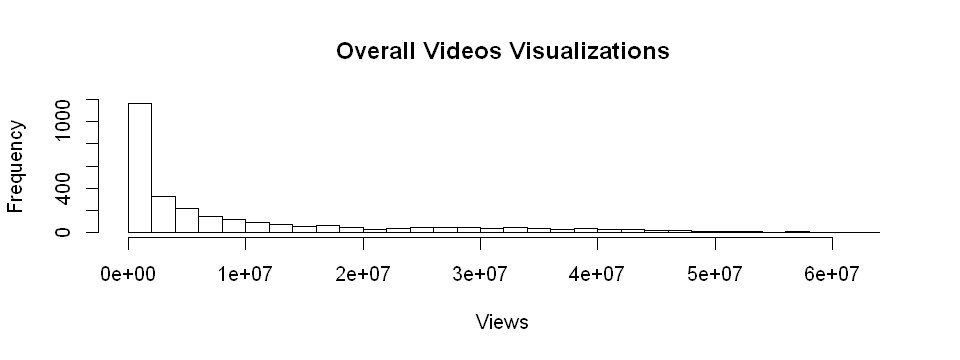

In [6]:
# sum the views count
video_count_pop <- video_count%>%
                   group_by(video_id)%>%
                   summarise(
                     overall_count=sum(count)
                   )

# checking the distribution
hist(video_count_pop$overall_count, breaks=40, main="Overall Videos Visualizations", xlab="Views")                

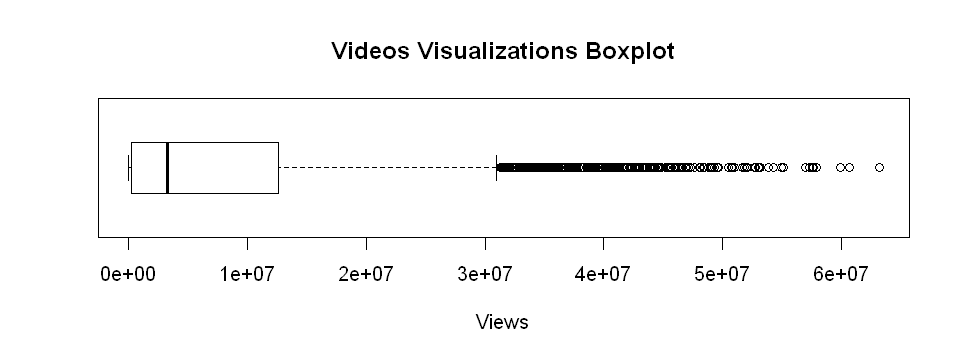

In [7]:
# Checking the boxplot and quartiles
boxplot(video_count_pop$overall_count, horizontal = TRUE, main="Videos Visualizations Boxplot", xlab="Views")

# We decided to use the 3rd quartile as a threshold of popular videos 
pop_q3rd <- quantile(video_count_pop$overall_count)[4]

# Let's classify is_popular using the threshold
video_count_pop <- video_count_pop%>%
                   mutate(
                     is_popular=ifelse(overall_count>pop_q3rd,TRUE, FALSE)                               
                   )

# Now we have popular video information
video_popular <- video_count%>%
                 inner_join(
                   video_count_pop,
                   by = "video_id"
                 )

## Second target : Classifying trends, stable and others for views timeseries
Solution: Extract the angular coefficient of a linear regression of video counts over time

In [8]:
# Defining utilities functions

# normalize the count to get the right coefficient and angle
normalize_range<-function(column, min_value, max_value){
    ((column - min(column)) / (max(column) - min(column)))*(max_value-min_value)+min_value
}

# get angular coefficient and angle of the linear regression
get_angular_coefficient<-function(video_count_agg){
    # normalize count range
    video_count_agg$count_norm = normalize_range(video_count_agg$count, 1,length(video_count_agg$count))
    # run regression
    model = lm(count_norm ~ day, data=video_count_agg)
    # extract the angular coefficient and angle of the regression line
    video_count_agg$angular_coef = coef(model)[2]
    video_count_agg$angle = atan( video_count_agg$angular_coef) * 180 / pi
    video_count_agg
}

In [9]:
# Some transformations
video_popular <- video_popular%>%
                 mutate(
                   date = ymd(date),
                   day = day(date)
                 )
# using mutate to get the coefficient and angle
video_count_coef <- video_popular%>%
                    group_by(video_id)%>%
                    do(get_angular_coefficient(.))%>%
                    ungroup()

### Checking the distribution of the angle

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -53.47  -42.87  -31.15  -10.83   33.73   51.17 

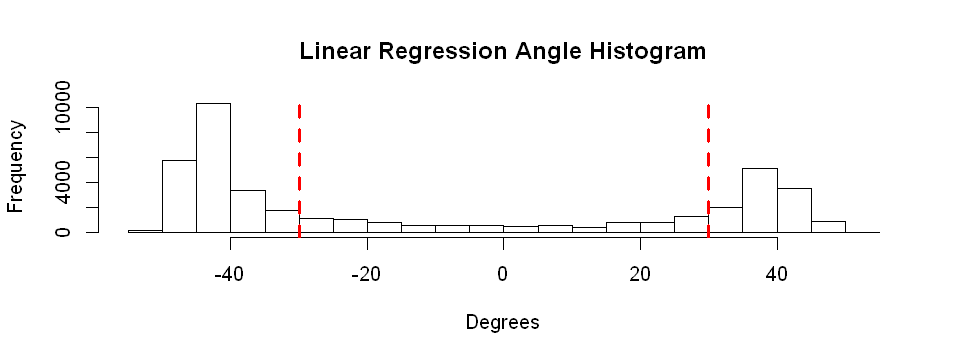

In [10]:
hist(video_count_coef$angle, breaks=20, main="Linear Regression Angle Histogram", xlab="Degrees")
abline(v=c(-30,30), col=c("red", "red"), lty=c(2,2), lwd=c(3, 3))

summary(video_count_coef$angle)

<span style="color:red">It's a bimodal distribution, we don't want to use quantiles or z-score as thresholds. So, we will visually select -30° to 30° to be our threshold. </span>

### Defining trend as angle < 30°, stationary between -30° and 30°

In [11]:
angle_sup=30
angle_inf=-30

### Wrapping things up 


In [12]:
video_classified <- video_count_coef%>%
                    mutate(
                       classification=ifelse(angle>=angle_sup,"Hot", "Everything else"),
                       classification=ifelse(angle<angle_sup & angle>angle_inf & is_popular,"Stable and Popular", classification ) 
                    )

video_classified%>%count(classification)

classification,n
Everything else,25800
Hot,11595
Stable and Popular,4380


### Awesome, now put this in a file

In [13]:
write.csv(video_classified, "data/challenge_2/video_classified.csv", row.names=F)

## Third target: Describe video types
* What are the main characteristics of the "hot videos"?
* After having identified the characteristics of the hot videos, how would you use this information from a product standpoint?

<span style="color:red">Please, for this solution check the link to [Notebook 2.2](Challenge 2.2 - Recommendation Engine.ipynb)</span>